# A3: Machine Translation + Transformer (st125338)

In [85]:
!pip list

Package                            Version
---------------------------------- -----------
aiohappyeyeballs                   2.4.4
aiohttp                            3.11.11
aiosignal                          1.3.2
alembic                            1.13.2
aniso8601                          9.0.1
annotated-types                    0.7.0
asttokens                          2.4.1
async-timeout                      5.0.1
attrs                              24.2.0
beautifulsoup4                     4.12.3
black                              24.8.0
bleach                             6.1.0
blinker                            1.8.2
blis                               1.2.0
cachetools                         5.5.0
catalogue                          2.0.10
certifi                            2024.7.4
cffi                               1.17.0
chardet                            3.0.4
charset-normalizer                 3.3.2
click                              8.1.7
cloudpathlib                       0.2

In [86]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import random, math, time

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Switching to {torch.cuda.get_device_name(device.index)} (Device {device.index})")

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Switching to NVIDIA GeForce RTX 3070 Laptop GPU (Device None)


In [87]:
# torch.cuda.get_device_name(0)

In [88]:
torch.__version__

'2.1.2+cu121'

In [89]:
torchtext.__version__

'0.16.2+cpu'

## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

In [90]:
import datasets

dataset = datasets.load_dataset('st125338/npu_a3_en_my')

C:\Users\ws-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ws-\.cache\huggingface\hub\datasets--st125338--npu_a3_en_my. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating test split: 100%|

In [91]:
dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'my'],
        num_rows: 9713
    })
    validation: Dataset({
        features: ['en', 'my'],
        num_rows: 99
    })
    test: Dataset({
        features: ['en', 'my'],
        num_rows: 100
    })
})

## 2. EDA - simple investigation

In [92]:
train = [(row['en'], row['my']) for row in dataset['train']]

In [93]:
test = [(row['en'], row['my']) for row in dataset['test']]

In [94]:
val = [(row['en'], row['my']) for row in dataset['validation']]

In [95]:
#let's take a look at one example of train
sample = train[3]
sample

('Jeremy Pitt answered the laugh by giggling and throwing an uppercut into the laughers face',
 'ကတခစ်ခစ်ရယ်လိုက်ပြီးနောက်ရယ်နေသူ၏မျက်နှာကိုပင့်လက်သီးတလုံးထိုးလိုက်ခြင်းဖြင့်ရယ်မောခြင်းကိုတုံ့ပြန်ခဲ့သည်။')

In [96]:
train_size = len(list(iter(train)))
train_size

9713

In [97]:
val_size = len(list(iter(val)))
val_size

99

In [98]:
test_size = len(list(iter(test)))
test_size

100

## 3. Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [99]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [100]:
# # Burmese word tokenizer
# import pyidaungsu as pds

# def pds_tokenizer(sentence):
#     return pds.tokenize(sentence, form="word")

In [101]:
# Myanmar language custom tokenization
"""

This code is updated version of this: https://gist.github.com/markdtw/e2a4e2ee7cef8ea6aed33bb47a97fba6
Ye Kyaw Thu, LST, NECTEC, Thailand updated followings:
-- added recursion limit
-- changed P_unigram and P_bigram as module level global variable
-- using binary ngram dictionary
--  set N value of this: "def __init__(self, datafile=None, unigram=True, N=102490):"
-- Last Updated: 5 Sept 2021

# References:
- Python implementation of Viterbi algorithm for word segmentation: 
- Updated version of this: https://gist.github.com/markdtw/e2a4e2ee7cef8ea6aed33bb47a97fba6
- A clean-up of this: http://norvig.com/ngrams/ch14.pdf
- For recursion limit: https://www.geeksforgeeks.org/python-handling-recursion-limit/
- A. Viterbi, "Error bounds for convolutional codes and an asymptotically optimum decoding algorithm," in IEEE Transactions on Information Theory, vol. 13, no. 2, pp. 260-269, April 1967, doi: 10.1109/TIT.1967.1054010.

"""

import math
import functools
import sys
import pickle

sys.setrecursionlimit(10**6)

uni_dict_bin = 'dataset/bins/unigram-word.bin'
bi_dict_bin = 'dataset/bins/bigram-word.bin'                

def read_dict (fileDICT):
    try:
        with open(fileDICT, 'rb') as input_file:
            dictionary = pickle.load(input_file)
            input_file.close()
    except FileNotFoundError:
        print('Dictionary file', fileDICT, ' not found!')
    return dictionary

class ProbDist(dict):
    ### Probability distribution estimated from unigram/bigram data
    def __init__(self, datafile=None, unigram=True, N=102490):
    #def __init__(self, datafile=None, unigram=True, N=1024908267229):
    #def __init__(self, datafile=None, unigram=True, N=8199266137832):
        #data = {}
        data = read_dict(datafile)
        for k, c in data.items():
            self[k] = self.get(k, 0) + c

        if unigram:
            self.unknownprob = lambda k, N: 10 / (N*10**len(k))    # avoid unknown long word
        else:
            self.unknownprob = lambda k, N: 1 / N

        self.N = N

    def __call__(self, key):
        if key in self:
            return self[key]/self.N
        else:
            return self.unknownprob(key, self.N)
        

P_unigram = ProbDist(uni_dict_bin, True)
P_bigram = ProbDist(bi_dict_bin, False)


def conditionalProb(word_curr, word_prev):
    ### Conditional probability of current word given the previous word.
    try:
        return P_bigram[word_prev + ' ' + word_curr]/P_unigram[word_prev]
    except KeyError:
        return P_unigram(word_curr)


@functools.lru_cache(maxsize=2**10)
#maxlen=20
def viterbi(text, prev='<S>', maxlen=20):
    if not text:
        return 0.0, []
    
    #print("text: ", text)
    textlen = min(len(text), maxlen)
    splits = [(text[:i + 1], text[i + 1:]) for i in range(textlen)]

    candidates = []
    #print("clear candidates!  candidates = []")
    for first_word, remain_word in splits:
        #pdb.set_trace()
        first_prob = math.log10(conditionalProb(first_word, prev))
        #print("first_prob of condProb(", first_word, ", ", prev, "): ", first_prob )
        remain_prob, remain_word = viterbi(remain_word, first_word)
        #print("remain_prob: ", remain_prob, ", remain_word: ", remain_word)
        candidates.append((first_prob + remain_prob, [first_word] + remain_word))
        #print("first_prob: ", str(first_prob), ", remain_prob: ", remain_prob, ", [first_word]:", [first_word], ", remain_word: ", remain_word)
        #print("Candidates: ", candidates)
        
    #print("max(candidates): " + str(max(candidates)))
    #print("====================")
    return max(candidates)

In [102]:
def my_tokenizer(text):
    if text is None:
        return []
    wordDelimiter= '|' # assign local variable delimiter

    input      = text[:]
    # text     = corpus['train'][0][TRG_LANGUAGE]
    listString = viterbi(input.replace(" ", "").strip()) # remove space between words and pass to viterbi()
    # print("listString: " + str(listString))
    wordStr    = wordDelimiter.join(listString[1])
    wordClean1 = wordStr.strip()
    wordClean2 = wordClean1.strip(wordDelimiter)    
    wordClean2 = wordClean2.split('|')                
    return wordClean2

In [103]:
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'my'

In [104]:
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = my_tokenizer

In [105]:
#example of tokenization of the english part
print("Sentence: ", sample[0])
print("Tokenization: ", token_transform[SRC_LANGUAGE](sample[0]))

Sentence:  Jeremy Pitt answered the laugh by giggling and throwing an uppercut into the laughers face
Tokenization:  ['Jeremy', 'Pitt', 'answered', 'the', 'laugh', 'by', 'giggling', 'and', 'throwing', 'an', 'uppercut', 'into', 'the', 'laughers', 'face']


In [106]:
#example of tokenization of the burmese part
print("Sentence: ", sample[1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](sample[1]))

Sentence:  ကတခစ်ခစ်ရယ်လိုက်ပြီးနောက်ရယ်နေသူ၏မျက်နှာကိုပင့်လက်သီးတလုံးထိုးလိုက်ခြင်းဖြင့်ရယ်မောခြင်းကိုတုံ့ပြန်ခဲ့သည်။
Tokenization:  ['က', 'တခစ်ခစ်', 'ရယ်', 'လိုက်', 'ပြီး', 'နောက်', 'ရယ်', 'နေ', 'သူ', '၏', 'မျက်နှာ', 'ကို', 'ပင့်', 'လက်သီး', 'တလုံး', 'ထိုး', 'လိုက်', 'ခြင်း', 'ဖြင့်', 'ရယ်မော', 'ခြင်း', 'ကို', 'တုံ့ပြန်', 'ခဲ့', 'သည်', '။']


A function to tokenize our input.

In [107]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [108]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [109]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [110]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[195, 11, 7, 0, 7]

In [111]:
import pickle

pickle.dump(vocab_transform, open('app/models/vocabs.pkl', 'wb'))

In [112]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[5]

'to'

In [113]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [114]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [115]:
#check unique vocabularies
len(mapping)

7111

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [116]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 128

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [117]:
batch_size = 128

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

Let's test the train loader.

In [118]:
for en, _, my in train_loader:
    break

In [119]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Burmese shape: ", my.shape)   # (batch_size, seq len)

English shape:  torch.Size([128, 37])
Burmese shape:  torch.Size([128, 59])


## 5. Design the model

<img src="../figures/transformer-encoder.png" >

### Encoder Layer

In [120]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attn_type):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, attn_type)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        return src

### Encoder

In [121]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, attn_type, max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attn_type)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src
            

### Mutli Head Attention Layer

<img src = "../figures/transformer-attention.png" width="700">

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

In [122]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device, attn_type):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        self.attn_type = attn_type
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
                
        # Additive attention parameters
        if self.attn_type == 'additive':
            self.W_q = nn.Linear(self.head_dim, self.head_dim)
            self.W_k = nn.Linear(self.head_dim, self.head_dim)
            self.v = nn.Linear(self.head_dim, 1)
        
        # Cosine attention parameter
        if self.attn_type == 'multiplicative':
            self.temperature = nn.Parameter(torch.ones(1))
            
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]
        
        # Calculate attention scores
        if self.attn_type == 'general':
            energy = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
            
        elif self.attn_type == 'additive':
            q_trans = self.W_q(Q).unsqueeze(3) # [batch, heads, q_len, 1, dim]
            k_trans = self.W_k(K).unsqueeze(2) # [batch, heads, 1, k_len, dim]
            energy = self.v(torch.tanh(q_trans + k_trans)).squeeze(-1) # Shape: [batch, heads, q_len, k_len]
            
        elif self.attn_type == 'multiplicative':
            Q_norm = Q / (Q.norm(dim=-1, keepdim=True) + 1e-8)
            K_norm = K / (K.norm(dim=-1, keepdim=True) + 1e-8)
            energy = self.temperature * torch.matmul(Q_norm, K_norm.transpose(-2, -1))
            # Q_norm = self.fc_q(Q) / self.scale
            # K_norm = self.fc_k(K)
            # energy = torch.matmul(Q_norm, K_norm.transpose(-2, -1))
            # Multiplicative attention: e_i = s^T W h_i

        else:
            raise ValueError(f"Unknown attention type: {self.attn_type}")
        
        #q = self.W(Q)
        #k = self.U(K)

        # # e = v ( tanh( W(Q) + U(K) ) )
        # energy = self.v(torch.tanh(q + k)) / self.scale
        # #energy = [batch_size, n heads, query len, key len, 1]

        # energy = energy.squeeze(4)
        # #energy = [batch_size, n heads, query len, key len]
                
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention
        

### Position-wise Feedforward Layer

In [123]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

### Decoder Layer

<img src = "../figures/transformer-decoder.png" >

In [124]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attn_type):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, attn_type)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, attn_type)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

### Decoder

In [125]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device, attn_type, max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attn_type)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [126]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## 6. Training

In [127]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [128]:
def initialize_model(attention_type):
    INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
    OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
    HID_DIM = 256
    ENC_LAYERS = 3
    DEC_LAYERS = 3
    ENC_HEADS = 8
    DEC_HEADS = 8
    ENC_PF_DIM = 512
    DEC_PF_DIM = 512
    ENC_DROPOUT = 0.1
    DEC_DROPOUT = 0.1
    
    enc = Encoder(INPUT_DIM, 
                  HID_DIM, 
                  ENC_LAYERS, 
                  ENC_HEADS, 
                  ENC_PF_DIM, 
                  ENC_DROPOUT, 
                  device,
                  attention_type)
    
    dec = Decoder(OUTPUT_DIM, 
                  HID_DIM, 
                  DEC_LAYERS, 
                  DEC_HEADS, 
                  DEC_PF_DIM, 
                  DEC_DROPOUT, 
                  device,
                  attention_type)
    
    SRC_PAD_IDX = PAD_IDX
    TRG_PAD_IDX = PAD_IDX
    
    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)

    return model

In [129]:
# input_dim   = len(vocab_transform[SRC_LANGUAGE])
# output_dim  = len(vocab_transform[TRG_LANGUAGE])
# hid_dim = 256
# enc_layers = 3
# dec_layers = 3
# enc_heads = 8
# dec_heads = 8
# enc_pf_dim = 512
# dec_pf_dim = 512
# enc_dropout = 0.1
# dec_dropout = 0.1

# SRC_PAD_IDX = PAD_IDX
# TRG_PAD_IDX = PAD_IDX

# enc = Encoder(input_dim, 
#               hid_dim, 
#               enc_layers, 
#               enc_heads, 
#               enc_pf_dim, 
#               enc_dropout, 
#               device)

# dec = Decoder(output_dim, 
#               hid_dim, 
#               dec_layers, 
#               dec_heads, 
#               dec_pf_dim, 
#               enc_dropout, 
#               device)

# model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
# model.apply(initialize_weights)

In [130]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

### General Attention

In [131]:
general_model = initialize_model('general')
    
count_parameters(general_model)

1820416
128000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1036288
128000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1036288
  4048
______
8106704


### Multiplicative Attention

In [132]:
multi_model = initialize_model('multiplicative')
    
count_parameters(multi_model)

1820416
128000
   256
   256
   256
   256
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1036288
128000
   256
   256
   256
   256
   256
   256
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1036288
  4048
______
810

### Additive Attention

In [133]:
add_model = initialize_model('additive')
    
count_parameters(add_model)

1820416
128000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
1036288
128000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
1310

In [134]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
general_optimizer = optim.Adam(general_model.parameters(), lr=lr)
general_criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

multi_optimizer = optim.Adam(multi_model.parameters(), lr=lr)
multi_criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

add_optimizer = optim.Adam(add_model.parameters(), lr=lr)
add_criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [135]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [136]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

In [137]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [138]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## General Attention Model Training

In [140]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

gen_save_path = f'app/models/general_model_v4.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(general_model, train_loader, general_optimizer, general_criterion, clip, train_loader_length)
    valid_loss = evaluate(general_model, valid_loader, general_criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(general_model.state_dict(), gen_save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 8m 42s
	Train Loss: 4.759 | Train PPL: 116.678
	 Val. Loss: 4.310 |  Val. PPL:  74.474
Epoch: 02 | Time: 8m 39s
	Train Loss: 4.145 | Train PPL:  63.146
	 Val. Loss: 3.985 |  Val. PPL:  53.794
Epoch: 03 | Time: 8m 40s
	Train Loss: 3.785 | Train PPL:  44.032
	 Val. Loss: 3.801 |  Val. PPL:  44.739
Epoch: 04 | Time: 8m 38s
	Train Loss: 3.499 | Train PPL:  33.092
	 Val. Loss: 3.711 |  Val. PPL:  40.905
Epoch: 05 | Time: 8m 38s
	Train Loss: 3.253 | Train PPL:  25.864
	 Val. Loss: 3.630 |  Val. PPL:  37.703
Epoch: 06 | Time: 8m 39s
	Train Loss: 3.032 | Train PPL:  20.748
	 Val. Loss: 3.591 |  Val. PPL:  36.262
Epoch: 07 | Time: 8m 34s
	Train Loss: 2.830 | Train PPL:  16.940
	 Val. Loss: 3.537 |  Val. PPL:  34.356
Epoch: 08 | Time: 8m 34s
	Train Loss: 2.641 | Train PPL:  14.032
	 Val. Loss: 3.539 |  Val. PPL:  34.424
Epoch: 09 | Time: 8m 44s
	Train Loss: 2.469 | Train PPL:  11.807
	 Val. Loss: 3.514 |  Val. PPL:  33.591
Epoch: 10 | Time: 8m 31s
	Train Loss: 2.307 | Train PPL

Text(0, 0.5, 'loss')

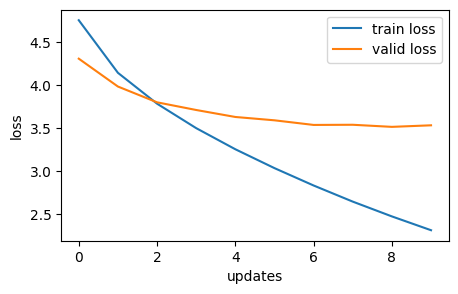

In [141]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [142]:
general_model.load_state_dict(torch.load(gen_save_path))
test_loss = evaluate(general_model, test_loader, general_criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.545 | Test PPL:  34.656 |


## Multiplicative Attention Model Training

In [143]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

multi_save_path = f'app/models/multi_model_v4.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(multi_model, train_loader, multi_optimizer, multi_criterion, clip, train_loader_length)
    valid_loss = evaluate(multi_model, valid_loader, multi_criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(multi_model.state_dict(), multi_save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 8m 30s
	Train Loss: 5.743 | Train PPL: 311.961
	 Val. Loss: 4.701 |  Val. PPL: 110.007
Epoch: 02 | Time: 8m 30s
	Train Loss: 4.447 | Train PPL:  85.365
	 Val. Loss: 4.148 |  Val. PPL:  63.289
Epoch: 03 | Time: 8m 53s
	Train Loss: 3.976 | Train PPL:  53.282
	 Val. Loss: 3.891 |  Val. PPL:  48.949
Epoch: 04 | Time: 9m 4s
	Train Loss: 3.653 | Train PPL:  38.594
	 Val. Loss: 3.762 |  Val. PPL:  43.032
Epoch: 05 | Time: 9m 7s
	Train Loss: 3.392 | Train PPL:  29.734
	 Val. Loss: 3.665 |  Val. PPL:  39.047
Epoch: 06 | Time: 9m 11s
	Train Loss: 3.159 | Train PPL:  23.540
	 Val. Loss: 3.623 |  Val. PPL:  37.461
Epoch: 07 | Time: 9m 6s
	Train Loss: 2.951 | Train PPL:  19.131
	 Val. Loss: 3.566 |  Val. PPL:  35.383
Epoch: 08 | Time: 9m 6s
	Train Loss: 2.758 | Train PPL:  15.761
	 Val. Loss: 3.565 |  Val. PPL:  35.333
Epoch: 09 | Time: 9m 13s
	Train Loss: 2.571 | Train PPL:  13.076
	 Val. Loss: 3.553 |  Val. PPL:  34.906
Epoch: 10 | Time: 9m 5s
	Train Loss: 2.406 | Train PPL:  11

Text(0, 0.5, 'loss')

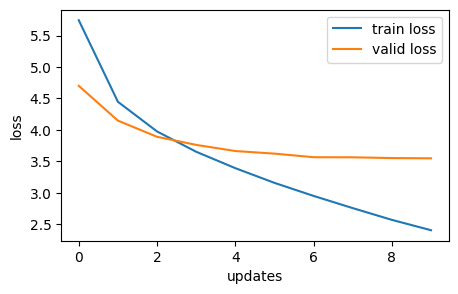

In [144]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [145]:
multi_model.load_state_dict(torch.load(multi_save_path))
test_loss = evaluate(multi_model, test_loader, multi_criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.584 | Test PPL:  36.017 |


## Additive Attention Model Training

In [146]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

add_save_path = f'app/models/add_model_v4.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(add_model, train_loader, add_optimizer, add_criterion, clip, train_loader_length)
    valid_loss = evaluate(add_model, valid_loader, add_criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(add_model.state_dict(), add_save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 13m 4s
	Train Loss: 5.747 | Train PPL: 313.315
	 Val. Loss: 4.685 |  Val. PPL: 108.294
Epoch: 02 | Time: 13m 19s
	Train Loss: 4.430 | Train PPL:  83.920
	 Val. Loss: 4.119 |  Val. PPL:  61.505
Epoch: 03 | Time: 13m 22s
	Train Loss: 3.955 | Train PPL:  52.192
	 Val. Loss: 3.886 |  Val. PPL:  48.716
Epoch: 04 | Time: 13m 21s
	Train Loss: 3.635 | Train PPL:  37.889
	 Val. Loss: 3.729 |  Val. PPL:  41.619
Epoch: 05 | Time: 13m 28s
	Train Loss: 3.369 | Train PPL:  29.059
	 Val. Loss: 3.646 |  Val. PPL:  38.310
Epoch: 06 | Time: 13m 18s
	Train Loss: 3.139 | Train PPL:  23.087
	 Val. Loss: 3.591 |  Val. PPL:  36.285
Epoch: 07 | Time: 13m 26s
	Train Loss: 2.931 | Train PPL:  18.746
	 Val. Loss: 3.548 |  Val. PPL:  34.748
Epoch: 08 | Time: 13m 13s
	Train Loss: 2.745 | Train PPL:  15.566
	 Val. Loss: 3.536 |  Val. PPL:  34.313
Epoch: 09 | Time: 13m 18s
	Train Loss: 2.563 | Train PPL:  12.976
	 Val. Loss: 3.522 |  Val. PPL:  33.836
Epoch: 10 | Time: 13m 20s
	Train Loss: 2.408 | 

Text(0, 0.5, 'loss')

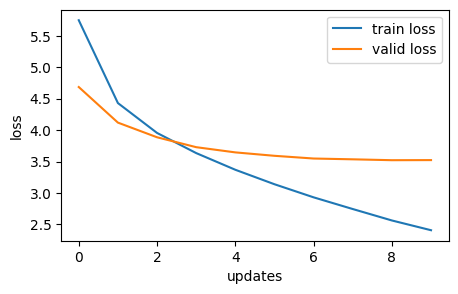

In [147]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [148]:
add_model.load_state_dict(torch.load(add_save_path))
test_loss = evaluate(add_model, test_loader, add_criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.555 | Test PPL:  34.980 |


## 7. Testing on sample

In [507]:
text_text = dataset['train'][13]
src_text = text_transform[SRC_LANGUAGE](text_text['en']).to(device).reshape(1, -1)
trg_text = text_transform[TRG_LANGUAGE](text_text['my']).to(device).reshape(1, -1)

In [548]:
text_text['en'], text_text['my']

('For Ballingers warnings see Ed Ballinger interview Apr 14 2004',
 'ဘယ်လ်လင်ဂျာ၏သတိပေးချက်များအတွက်၊၂၀၀၄ခုနှစ်ဧပြီလ၁၄ရက်နေ့ဘယ်လ်လင်ဂျာ၏အင်တာဗျူးကိုကြည့်ပါ။')

In [549]:
def perform_decoding(model, input_sequence, max_len=500, device=device):
    # Convert source text to model-compatible tensor format
    transformed_source = text_transform[SRC_LANGUAGE](input_sequence)
    source_tensor = transformed_source.to(device).view(1, -1)  # Create batch dimension
    
    # Initialize decoding process
    decoded_indices = [SOS_IDX]  # Starting with start-of-sequence token
    model.eval()  # Set model to evaluation mode
    
    # Iterate through sequence generation steps
    for step_num in range(max_len):
        # Prepare current sequence for model input
        decoder_input = torch.tensor(decoded_indices, dtype=torch.long, device=device).unsqueeze(0)
        
        # Disable gradient computation during inference
        with torch.no_grad():
            model_outputs, attention_weights = model(source_tensor, decoder_input)
        
        # Obtain next token prediction (greedy selection)
        final_output = model_outputs.softmax(dim=-1)
        predicted_index = final_output.argmax(dim=2)[:, -1].item()
        
        # Update sequence with new prediction
        decoded_indices.append(predicted_index)
        
        # Check for early termination with end-of-sequence token
        if predicted_index == EOS_IDX:
            break
    
    # Convert indices to human-readable tokens
    translated_tokens = [
        mapping[TRG_LANGUAGE][idx] 
        for idx in decoded_indices[1:]  # Remove initial SOS token
    ]
    
    return translated_tokens, attention_weights

### General Inference Testing

In [550]:
general_src_sentence = text_text['en']

general_output_sentence, general_attentions = perform_decoding(general_model, general_src_sentence, max_len=500, device=device)
print("Predicted Sentence:", ' '.join(general_output_sentence))

Predicted Sentence: ၏ အင်တာဗျူး ရက် ၊ အင်တာဗျူး တွင် ကူညီ ပေး ခြင်း အတွက် ၊ အင်တာဗျူး ၄ ကို ကြည့် ပါ ။ <eos>


### Multiplicative Inference Testing

In [551]:
multi_src_sentence = text_text['en']

multi_output_sentence, multi_attentions = perform_decoding(multi_model, multi_src_sentence, max_len=500, device=device)
print("Predicted Sentence:", ' '.join(multi_output_sentence))

Predicted Sentence: ၏ အင်တာဗျူး ၊ ထောက်လှမ်း ရေး အစီရင်ခံစာ ၊ အင်တာဗျူး ၄ ၃ ၂ ၊ ၏ အင်တာဗျူး ကို ကြည့် ပါ ။ <eos>


### Additive Inference Testing

In [552]:
add_src_sentence = text_text['en']

add_output_sentence, add_attentions = perform_decoding(add_model, add_src_sentence, max_len=500, device=device)
print("Predicted Sentence:", ' '.join(add_output_sentence))

Predicted Sentence: ကေအက်စ်အမ် ၏ အင်တာဗျူး ၊ ကေအက်စ်အမ် သည် အယ်လ် ကိုင် ဒါ ကို ကြည့် ရန် ၊ ၂၀၀၁ ခု နှစ် ၊ ၂၀၀၁ ခု နှစ် ၊ စက်တင်ဘာ လ ၁၄ ရက်နေ့ ၊ စက်တင်ဘာ လ ၁၄ ရက်နေ့ ၊ စက်တင်ဘာ လ ၁၄ ရက်နေ့ တွင် ကြည့် ပါ ။ <eos>


## Attention Testing

In [539]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [443]:
text_text = dataset['train'][50]
text_text

{'en': 'The children attending our shows prepare in advance for their theatrical experience through their classs curriculum',
 'my': 'ကျွန်ုပ်တို့၏ရှိုးပွဲများကိုတက်ရောက်သည့်ကလေးများသည်၎င်းတို့၏အတန်း၏သင်ရိုးညွှန်းတမ်းမှတစ်ဆင့်၎င်းတို့၏ပြဇာတ်အတွေ့အကြုံအတွက်ကြိုတင်ပြင်ဆင်ထားကြသည်'}

In [444]:
text_text['en']

'The children attending our shows prepare in advance for their theatrical experience through their classs curriculum'

In [445]:
text_text['my']

'ကျွန်ုပ်တို့၏ရှိုးပွဲများကိုတက်ရောက်သည့်ကလေးများသည်၎င်းတို့၏အတန်း၏သင်ရိုးညွှန်းတမ်းမှတစ်ဆင့်၎င်းတို့၏ပြဇာတ်အတွေ့အကြုံအတွက်ကြိုတင်ပြင်ဆင်ထားကြသည်'

In [446]:
src_text = text_transform[SRC_LANGUAGE](text_text['en']).to(device)
src_text

tensor([   2,   10,  231, 3477,   82,  363, 5021,    9, 1912,   16,   58, 4000,
         918,  176,   58,    0, 4627,    3], device='cuda:0')

In [447]:
trg_text = text_transform[TRG_LANGUAGE](text_text['my']).to(device)
trg_text

tensor([   2,   86,   20,   23, 2583,    7,    6,  853,   45,    8,   74,    7,
           5,   81,   20,   23, 1485,   23, 3100,   31,   15,  672,   81,   20,
          23,  610,  882,   41,  645,  462,   39,   44,    5,    3],
       device='cuda:0')

In [448]:
src_text = src_text.reshape(1, -1)  #because batch_size is 1

In [449]:
trg_text = trg_text.reshape(1, -1)

In [450]:
src_text.shape, trg_text.shape

(torch.Size([1, 18]), torch.Size([1, 34]))

In [451]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [452]:
general_model.load_state_dict(torch.load(gen_save_path))

general_model.eval()
with torch.no_grad():
    g_output, g_attentions = general_model(src_text, trg_text) #turn off teacher forcing

In [453]:
g_output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 34, 4048])

Since batch size is 1, we just take off that dimension

In [454]:
g_output = g_output.squeeze(0)

In [455]:
g_output.shape

torch.Size([34, 4048])

We shall remove the first token since it's zeroes anyway

In [456]:
g_output = g_output[1:]
g_output.shape #trg_len, trg_output_dim

torch.Size([33, 4048])

Then we just take the top token with highest probabilities

In [457]:
g_output_max = g_output.argmax(1) #returns max indices

In [458]:
g_output_max

tensor([ 20,  23,   8,   7,   8,   8,  35,   8,  74,   7,   8,  81,  20,  23,
          0,  23, 428,  31,  15,  24,  86,  20,  23,   0,   7,  41, 252, 462,
         39,  44,   5,   4,   7], device='cuda:0')

Get the mapping of the target language

In [459]:
g_mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [460]:
for token in g_output_max:
    print(g_mapping[token.item()])

တို့
၏
က
များ
က
က
ရန်
က
လေး
များ
က
၎င်း
တို့
၏
<unk>
၏
အရေးကြီး
မှ
တစ်
ခု
ကျွန်ုပ်
တို့
၏
<unk>
များ
အတွက်
အကောင်းဆုံး
ပြင်ဆင်
ထား
ကြ
သည်
။
များ


Let's display the attentions to understand how the source text links with the generated text

In [461]:
g_attentions.shape

torch.Size([1, 8, 34, 18])

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [462]:
g_attention = g_attentions[0, 0, :, :]
g_attention.shape

torch.Size([34, 18])

In [463]:
g_src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](text_text['en']) + ['<eos>']
g_src_tokens

['<sos>',
 'The',
 'children',
 'attending',
 'our',
 'shows',
 'prepare',
 'in',
 'advance',
 'for',
 'their',
 'theatrical',
 'experience',
 'through',
 'their',
 'classs',
 'curriculum',
 '<eos>']

In [464]:
g_trg_tokens = ['<sos>'] + [g_mapping[token.item()] for token in g_output_max]
g_trg_tokens

['<sos>',
 'တို့',
 '၏',
 'က',
 'များ',
 'က',
 'က',
 'ရန်',
 'က',
 'လေး',
 'များ',
 'က',
 '၎င်း',
 'တို့',
 '၏',
 '<unk>',
 '၏',
 'အရေးကြီး',
 'မှ',
 'တစ်',
 'ခု',
 'ကျွန်ုပ်',
 'တို့',
 '၏',
 '<unk>',
 'များ',
 'အတွက်',
 'အကောင်းဆုံး',
 'ပြင်ဆင်',
 'ထား',
 'ကြ',
 'သည်',
 '။',
 'များ']

In [553]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm

for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "Myanmar" in font or "Pyidaungsu" in font:
        print(font)  # Print the path to any Myanmar-compatible font

font_path = font

# Set the font to support Burmese
def set_burmese_font():
    # You may need to update the font path based on your OS
    if not fm.findfont(fm.FontProperties(fname=font_path)):
        print("Burmese font not found. Using default font.")
    else:
        plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()

set_burmese_font()  # Apply Burmese font setting

# Display attention with Burmese support
def display_attention(sentence, translation, attention):
    print(f"Attention shape: {attention.shape}")  # Debugging line
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    # Ensure attention has only 2 dimensions
    if len(attention.shape) > 2:
        attention = attention[0, 0, :, :]
    attention = attention.squeeze(1).cpu().detach().tolist()

    cax = ax.matshow(attention, cmap='bone')
    ax.tick_params(labelsize=10)

    y_ticks = [''] + translation
    x_ticks = [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45, fontproperties=fm.FontProperties(fname=font_path))
    ax.set_yticklabels(y_ticks, fontproperties=fm.FontProperties(fname=font_path))

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


C:\Users\ws-\AppData\Local\Microsoft\Windows\Fonts\Pyidaungsu-2.5.3_Regular.ttf


Attention shape: torch.Size([34, 18])


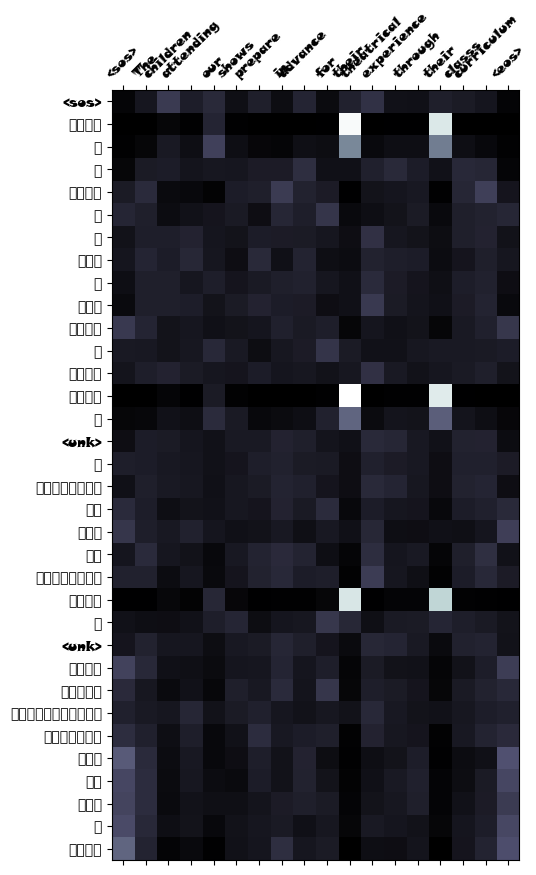

In [554]:
display_attention(g_src_tokens, g_trg_tokens, g_attention)

### Multiplicative Attention Testing

In [467]:
multi_model.load_state_dict(torch.load(multi_save_path))

multi_model.eval()
with torch.no_grad():
    m_output, m_attentions = general_model(src_text, trg_text) #turn off teacher forcing

In [468]:
m_output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 34, 4048])

Since batch size is 1, we just take off that dimension

In [469]:
m_output = m_output.squeeze(0)

In [470]:
m_output.shape

torch.Size([34, 4048])

We shall remove the first token since it's zeroes anyway

In [471]:
m_output = m_output[1:]
m_output.shape #trg_len, trg_output_dim

torch.Size([33, 4048])

Then we just take the top token with highest probabilities

In [472]:
m_output_max = m_output.argmax(1) #returns max indices

In [473]:
m_output_max

tensor([ 20,  23,   8,   7,   8,   8,  35,   8,  74,   7,   8,  81,  20,  23,
          0,  23, 428,  31,  15,  24,  86,  20,  23,   0,   7,  41, 252, 462,
         39,  44,   5,   4,   7], device='cuda:0')

Get the mapping of the target language

In [474]:
m_mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [475]:
for token in m_output_max:
    print(m_mapping[token.item()])

တို့
၏
က
များ
က
က
ရန်
က
လေး
များ
က
၎င်း
တို့
၏
<unk>
၏
အရေးကြီး
မှ
တစ်
ခု
ကျွန်ုပ်
တို့
၏
<unk>
များ
အတွက်
အကောင်းဆုံး
ပြင်ဆင်
ထား
ကြ
သည်
။
များ


Let's display the attentions to understand how the source text links with the generated text

In [476]:
m_attentions.shape

torch.Size([1, 8, 34, 18])

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [477]:
m_attentions = m_attentions[0, 0, :, :]
m_attentions.shape

torch.Size([34, 18])

In [478]:
m_src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](text_text['en']) + ['<eos>']
m_src_tokens

['<sos>',
 'The',
 'children',
 'attending',
 'our',
 'shows',
 'prepare',
 'in',
 'advance',
 'for',
 'their',
 'theatrical',
 'experience',
 'through',
 'their',
 'classs',
 'curriculum',
 '<eos>']

In [479]:
m_trg_tokens = ['<sos>'] + [m_mapping[token.item()] for token in m_output_max]
m_trg_tokens

['<sos>',
 'တို့',
 '၏',
 'က',
 'များ',
 'က',
 'က',
 'ရန်',
 'က',
 'လေး',
 'များ',
 'က',
 '၎င်း',
 'တို့',
 '၏',
 '<unk>',
 '၏',
 'အရေးကြီး',
 'မှ',
 'တစ်',
 'ခု',
 'ကျွန်ုပ်',
 'တို့',
 '၏',
 '<unk>',
 'များ',
 'အတွက်',
 'အကောင်းဆုံး',
 'ပြင်ဆင်',
 'ထား',
 'ကြ',
 'သည်',
 '။',
 'များ']

C:\Users\ws-\AppData\Local\Temp\ipykernel_7032\4006327969.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45, name='Source Text')
C:\Users\ws-\AppData\Local\Temp\ipykernel_7032\4006327969.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks, name='Target Text')
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.


Attention shape: torch.Size([34, 18])


findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Target Text' not found.
findfont: Font family 'Target Text' not found.
findfont: Font family 'Target Text' not found.
C:\Users\ws-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-pac

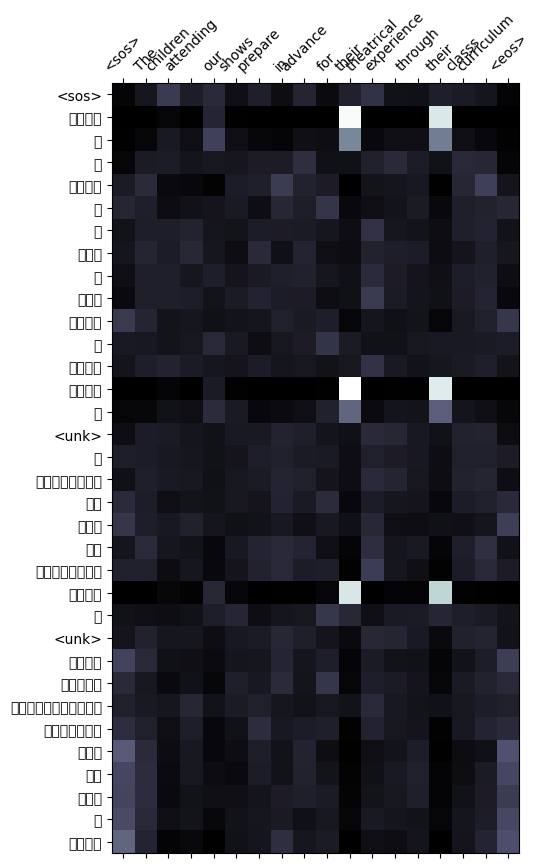

In [480]:
display_attention(m_src_tokens, m_trg_tokens, m_attentions)

### Additive Attention Testing

In [481]:
add_model.load_state_dict(torch.load(add_save_path))

add_model.eval()
with torch.no_grad():
    a_output, a_attentions = add_model(src_text, trg_text) #turn off teacher forcing

In [482]:
a_output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 34, 4048])

Since batch size is 1, we just take off that dimension

In [483]:
a_output = a_output.squeeze(0)

In [484]:
a_output.shape

torch.Size([34, 4048])

We shall remove the first token since it's zeroes anyway

In [485]:
a_output = a_output[1:]
a_output.shape #trg_len, trg_output_dim

torch.Size([33, 4048])

Then we just take the top token with highest probabilities

In [486]:
a_output_max = a_output.argmax(1) #returns max indices

In [487]:
a_output_max

tensor([ 20,  23,  46,   7,   5,   8,  16,   8,  74,   7,   5,  81,  20,  23,
        237,  31, 237,  31,  15,  80,  64,  20,  23, 237, 185,   6,  19, 462,
         55,  16,  29,  19,   6], device='cuda:0')

Get the mapping of the target language

In [488]:
a_mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [489]:
for token in a_output_max:
    print(a_mapping[token.item()])

တို့
၏
လူ
များ
သည်
က
သော
က
လေး
များ
သည်
၎င်း
တို့
၏
အမည်
မှ
အမည်
မှ
တစ်
ယောက်
သာ
တို့
၏
အမည်
ထုတ်
ကို
၊
ပြင်ဆင်
ချက်
သော
ပြီး
၊
ကို


Let's display the attentions to understand how the source text links with the generated text

In [490]:
a_attentions.shape

torch.Size([1, 8, 34, 18])

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [491]:
a_attentions = a_attentions[0, 0, :, :]
a_attentions.shape

torch.Size([34, 18])

In [492]:
a_src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](text_text['en']) + ['<eos>']
a_src_tokens

['<sos>',
 'The',
 'children',
 'attending',
 'our',
 'shows',
 'prepare',
 'in',
 'advance',
 'for',
 'their',
 'theatrical',
 'experience',
 'through',
 'their',
 'classs',
 'curriculum',
 '<eos>']

In [493]:
a_trg_tokens = ['<sos>'] + [a_mapping[token.item()] for token in a_output_max]
a_trg_tokens

['<sos>',
 'တို့',
 '၏',
 'လူ',
 'များ',
 'သည်',
 'က',
 'သော',
 'က',
 'လေး',
 'များ',
 'သည်',
 '၎င်း',
 'တို့',
 '၏',
 'အမည်',
 'မှ',
 'အမည်',
 'မှ',
 'တစ်',
 'ယောက်',
 'သာ',
 'တို့',
 '၏',
 'အမည်',
 'ထုတ်',
 'ကို',
 '၊',
 'ပြင်ဆင်',
 'ချက်',
 'သော',
 'ပြီး',
 '၊',
 'ကို']

Attention shape: torch.Size([34, 18])


C:\Users\ws-\AppData\Local\Temp\ipykernel_7032\4006327969.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45, name='Source Text')
C:\Users\ws-\AppData\Local\Temp\ipykernel_7032\4006327969.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks, name='Target Text')
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source T

C:\Users\ws-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4142 (\N{MYANMAR VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found.
findfont: Font family 'Source Text' not found

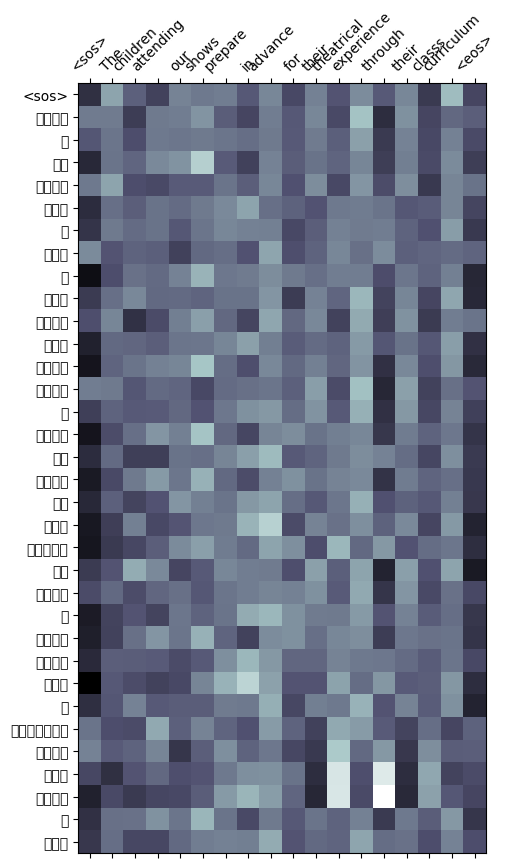

In [494]:
display_attention(a_src_tokens, a_trg_tokens, a_attentions)